In [173]:
import pandas as pd
from collections import Counter
import requests
from typing import Dict, Tuple,List
import matplotlib.pyplot as plt
import os

In [ ]:
tokenFile='token.ini'
dirData='data'

In [ ]:
# Converts params from human-readable tuple into url request form
def setParams(searchCriteria: Tuple,maxRows: int=None):
    searchCriteria=searchCriteria
    params=[('fq',q) for q in searchCriteria]
    params[0]=('q',params[0][1])
    if maxRows:
        rows=[('rows',str(int(maxRows)))]
    else:
        rows=[('rows',str(int(2000)))]
    params=tuple(params+rows)
    return params

In [ ]:
# Parameters for requests. The token can be obtained via Ads Settings->API Token
with open(tokenFile) as f:
    token = str(f.readline()).rstrip()
AdsUrl='https://api.adsabs.harvard.edu/v1/search/query'
headers = {'Authorization': 'Bearer '+token}

In [ ]:
# Making a request with some additional specifier
def requestCounts(year: int, additional: str='')->int:
    searchCriteria=('year:'+str(year),'database:astronomy',
                    'property:refereed','abs:"machine learning"', additional)
    if additional!='':
        searchCriteria=searchCriteria+(additional,)
    params=setParams(searchCriteria,maxRows=10)
    response = requests.get(url=AdsUrl, headers=headers, params=params)
    count=response.json()['response']['numFound']
    return count

In [ ]:
def responseToPandas(response: list):
    df=pd.DataFrame(columns=['keyword'])
    for rec in response:
        df=df.append(rec,ignore_index=True)
    return df

In [192]:
topics=['Earth','Solar','Exoplanet','Galaxy','cosmology','Gravitational Waves','High Energy',
'ISM','Sun','asteroids','binaries','galaxies','gravitational lensing',
'large-scale structure','stars','supernovae','quasars','pulsar','planets and satellites']
topics=[t.lower() for t in topics]
common=['survey','catalog','technique','method','machine learning','computer science']

In [193]:
def request(year: int,additional:str=''):
    searchCriteria=('year:'+str(year),'database:astronomy','property:refereed','abs:"machine learning"')
    if additional!='':
        searchCriteria=searchCriteria+(additional,)
    requester.setParams(searchCriteria)
    requester.loadData()
    df=responseToPandas(requester.response.json()['response']['docs'])
    return df

In [194]:
def getKeywords(df):
    keywords=[]
    for k in df['keyword']:
        if type(k)==list:
            keywords=keywords+k
    keywordsCount=pd.DataFrame(columns=['keyword','count'])
    keywordsCount['keyword']=Counter(keywords).keys()
    keywordsCount['count']=Counter(keywords).values()
    keywordsCount['keyword']=keywordsCount['keyword'].map(lambda s: s.lower())
    return keywordsCount

In [195]:
### For checking year by year if I missed any topical words ###
def checkNewKeywords(keywordsCount,topics,common):
    mask=keywordsCount['keyword'].map(lambda row: any([topic in row for topic in common]))
    keywordWork=keywordsCount[~mask]
    mask=keywordWork['keyword'].map(lambda row: any([topic in row for topic in topics]))
    keywordWork=keywordWork[~mask]
    keywordWork.sort_values('count',ascending=False)
    return keywordWork

In [196]:
def getTopics(keywordsCount,topics):
    mask=keywordsCount['keyword'].map(lambda row: any([topic in row for topic in topics]))
    keywordWork=keywordsCount[mask]
    topicsCount={}
    for topic in topics:
        df=keywordsCount[keywordsCount['keyword'].map(lambda row: topic in row)]
        topicsCount[topic]=df['count'].sum()
    return topicsCount

In [197]:
statByYears=pd.DataFrame(columns=['year']+topics)
for year in years:
    df=request(year)
    keywordsCount=getKeywords(df)
    topicsCount=getTopics(keywordsCount,topics)
    topicsCount['year']=year
    statByYears=statByYears.append(topicsCount,ignore_index=True)

In [200]:
statByYears['sun_total']=statByYears['sun']+statByYears['solar']
statByYears['exoplanets_total']=statByYears['exoplanet']+statByYears['planets and satellites']

In [201]:
statByYears

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,5,0,1,4,0,0,1,3,...,7,0,1,2,0,0,0,0,8,0
1,2011,0,0,0,1,4,0,1,3,0,...,2,0,0,1,0,1,0,0,0,0
2,2012,2,3,0,0,6,0,2,0,0,...,13,0,1,9,1,1,1,0,3,0
3,2013,0,3,0,1,6,0,4,0,6,...,16,0,1,10,1,2,1,0,9,0
4,2014,1,6,0,1,12,1,5,1,0,...,21,2,0,9,1,1,3,0,6,0
5,2015,2,16,0,5,22,0,8,6,8,...,27,3,2,12,4,2,1,1,24,1
6,2016,8,12,1,2,27,0,6,3,3,...,56,0,5,28,5,3,4,5,15,6
7,2017,9,11,1,7,20,1,7,9,15,...,53,4,2,21,4,2,1,2,26,3
8,2018,23,32,0,11,30,2,18,16,8,...,118,4,7,50,1,9,5,8,40,8
9,2019,26,45,3,18,65,2,42,21,13,...,173,9,9,40,6,10,2,17,58,20


In [214]:
cols=list(statByYears.columns)
cols=[col for col in cols if col not in ['year','solar','sun','exoplanet','planets and satellites']]

In [217]:
import matplotlib.pyplot as plt

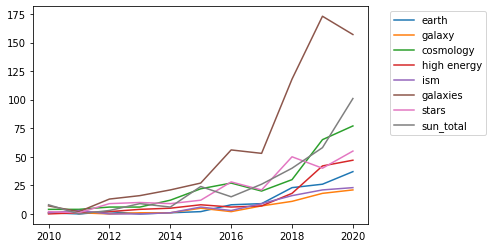

In [238]:
for col in cols:
    if any(statByYears[statByYears['year']==2020][col]>20):
        plt.plot(statByYears['year'],statByYears[col],label=col)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

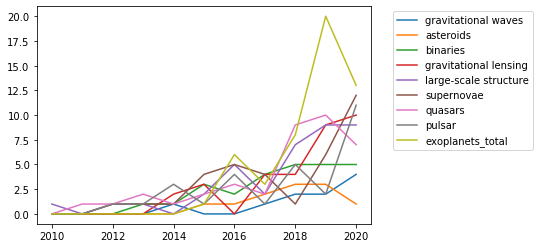

In [239]:
for col in cols:
    if any(statByYears[statByYears['year']==2020][col]<=20):
        plt.plot(statByYears['year'],statByYears[col],label=col)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [240]:
statByYears.to_csv('topicsFromKeywords.csv',index=False)

In [243]:
### check total number of papers with given keywords ###
statByYearsTotal=pd.DataFrame(columns=['year']+topics)
for year in years:
    print(year)
    counts={'year':year}
    for topic in topics:
        c=requestCounts(year,additional='keyword:"'+topic+'"')
        counts[topic]=c

    statByYearsTotal=statByYearsTotal.append(counts,ignore_index=True)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [245]:
statByYearsTotal['sun_total']=statByYearsTotal['sun']+statByYearsTotal['solar']
statByYearsTotal['exoplanets_total']=statByYearsTotal['exoplanet']+statByYearsTotal['planets and satellites']

In [251]:
statByYearsRatio=statByYears.div(statByYearsTotal,fill_value=0)

ZeroDivisionError: division by zero

In [252]:
statByYearsTotal

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,3,0,5,4,0,0,0,3,...,5,0,1,3,0,0,0,0,6,0
1,2011,0,0,0,5,3,0,1,1,0,...,5,0,0,1,1,1,0,0,0,0
2,2012,2,3,0,6,5,0,2,0,3,...,6,0,1,8,1,1,1,0,6,0
3,2013,0,4,0,10,6,1,3,0,4,...,10,0,1,6,1,2,1,0,8,0
4,2014,1,6,0,14,9,1,4,1,6,...,14,2,0,10,1,1,3,0,12,0
5,2015,2,15,0,28,20,1,7,2,15,...,28,3,2,16,4,2,1,1,30,1
6,2016,7,11,1,35,21,0,7,2,11,...,35,0,5,21,5,2,4,4,22,5
7,2017,4,10,1,37,17,1,6,4,10,...,37,4,2,24,4,2,1,1,20,2
8,2018,16,31,0,70,27,2,17,7,31,...,70,4,7,46,1,6,5,6,62,6
9,2019,20,43,1,105,51,2,34,10,43,...,105,9,9,63,5,10,2,13,86,14


In [253]:
statByYears

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,5,0,1,4,0,0,1,3,...,7,0,1,2,0,0,0,0,8,0
1,2011,0,0,0,1,4,0,1,3,0,...,2,0,0,1,0,1,0,0,0,0
2,2012,2,3,0,0,6,0,2,0,0,...,13,0,1,9,1,1,1,0,3,0
3,2013,0,3,0,1,6,0,4,0,6,...,16,0,1,10,1,2,1,0,9,0
4,2014,1,6,0,1,12,1,5,1,0,...,21,2,0,9,1,1,3,0,6,0
5,2015,2,16,0,5,22,0,8,6,8,...,27,3,2,12,4,2,1,1,24,1
6,2016,8,12,1,2,27,0,6,3,3,...,56,0,5,28,5,3,4,5,15,6
7,2017,9,11,1,7,20,1,7,9,15,...,53,4,2,21,4,2,1,2,26,3
8,2018,23,32,0,11,30,2,18,16,8,...,118,4,7,50,1,9,5,8,40,8
9,2019,26,45,3,18,65,2,42,21,13,...,173,9,9,40,6,10,2,17,58,20
